# <center><u><font color='red'>Projet 8 : Déployez un modèle dans le cloud</font></u><br>

   L'entreprise "Fruits" cherche à proposer des solutions innovantes en appliquant des traitements spécifiques pour chaque espèce de fruits et pour la récolte des fruits en développant des robots cueilleurs intelligents.
   
   Pour arriver à cet objectif final, cette start-up souhaite dans un premier temps se faire connaître en mettant à disposition du grand public une application mobile qui permettrait aux utilisateurs de prendre en photo un fruit et d'obtenir des informations sur celui-ci.
   
   En tant que Data Scientist, je dois pour ce projet, mettre en place les premières étapes nécessaires à une classification d'image soit un préprocessing des images et une réduction de dimension. Ces étapes seront à réaliser dans une architecture Big Data pour pallier au fait que le nombre d'images accroîtra de façon exponentielle.
   
   Ce projet se base sur le jeu de données Fruits360 et plus particulièrement sur les données d'entraînement qui sont au nombre de 67692 images pour 131 fuits. Chaque fruit est photographié sous 3 axes et les images produites sont de taille 100x100 pixels.
   
   Le projet est réalisé sur une machine EC2 xlarge d'Amazon avec Ubuntu 18 
   
   L'environement Big Data a été implémenté par Pyspark, Spark3.0.1 associé à Hadoop 3.2.
   
   Un échantillon de 1310 images représentant les 131 fruits (donc 10 images par fruit) sera utilisé pour ce projet. Il sera sauvegardé sur le Cloud S3 d'Amazon et l'accès à ces images pour le notebook se fera par boto3.
   
   La recherche des features se fera grâce à un CNN réseau de neurones qui se basera sur le modèle VGG16 pré-entrainé sur une base d'images riche (Imagenet).

# <font color='green'>Importation librairie</font>

In [1]:
#pip install pyspark==2.3.0

# Librairies
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

 
# image
from PIL import Image
import io
from io import StringIO
from skimage.io import imread, imshow
#warnings.filterwarnings('ignore')
import cv2

# S3 AWS
import boto3

# Spark
import findspark  #Findspark : Utiliser spark avec jupyter notebook
findspark.init('/home/ubuntu/spark-3.0.1-bin-hadoop3.2')

# Pyspark.
import pyspark
from pyspark.sql import *
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, Row
from pyspark.sql.functions import input_file_name, udf, col, pandas_udf, PandasUDFType
from pyspark.sql.types import ArrayType, StringType, IntegerType, DoubleType, DataType, FloatType
from pyspark.ml.feature import PCA
from pyspark.ml.linalg import Vectors, VectorUDT, DenseVector
from pyspark.ml.feature import StandardScaler


# Tensorflow
import tensorflow as tf
#from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array


In [2]:
!java -version


openjdk version "1.8.0_292"
OpenJDK Runtime Environment (build 1.8.0_292-8u292-b10-0ubuntu1~18.04-b10)
OpenJDK 64-Bit Server VM (build 25.292-b10, mixed mode)


# <font color='green'>Load des Clés d'accès à S3</font>

In [3]:
AWS_S3_BUCKET = 'p8-ald'
#path_local = '/Users/amandinelecerfdefer/Desktop/Formation_Data_Scientist_OC/WORK-projet8/Data/P8_data/*/'


In [4]:
with open('/home/ubuntu/.jupyter/MyNotebooks/keys.txt','r') as f:
    msg = f.read()
    ID = str(msg).split('\n')[0]
    KEY = msg.split('\n')[1]
    os.environ["AWS_ACCESS_KEY_ID"]=ID
    access_id = ID
    os.environ["AWS_SECRET_ACCESS_KEY"]=KEY
    access_key = KEY
    

In [5]:
#os.environ['JAVA_HOME'] = "/usr/bin/java"


# <font color='green'>Entraînement manuel sur une image</font>

## <font color='blue'>Load depuis S3 Amazon</font>

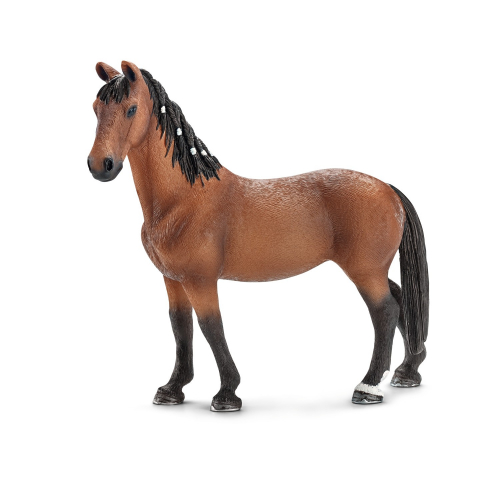

Largeur : 500 px, hauteur : 500 px


In [6]:
import boto3
from io import BytesIO
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
    
resource = boto3.resource('s3', region_name='eu-west-3')
bucket = resource.Bucket(AWS_S3_BUCKET)
image_object = bucket.Object('cheval.jpeg')
#image = mpimg.imread(BytesIO(image_object.get()['Body'].read()), 'jpeg')
#plt.imshow(image)

image = Image.open(BytesIO(image_object.get()['Body'].read())).convert('RGB')
image.show()
# Récupérer et afficher la taille de l'image (en pixels)
w, h = image.size
print("Largeur : {} px, hauteur : {} px".format(w, h))


In [7]:
#opencvImage = cv2.cvtColor(np.array(image), cv2.COLOR_RGB2BGR)
#plt.imshow(cv2.cvtColor(horse_img, cv2.COLOR_RGB2BGR))


## <font color='blue'>Recherche de features sur une image</font>

Text(0.5, 1.0, 'ORB Interest Points')

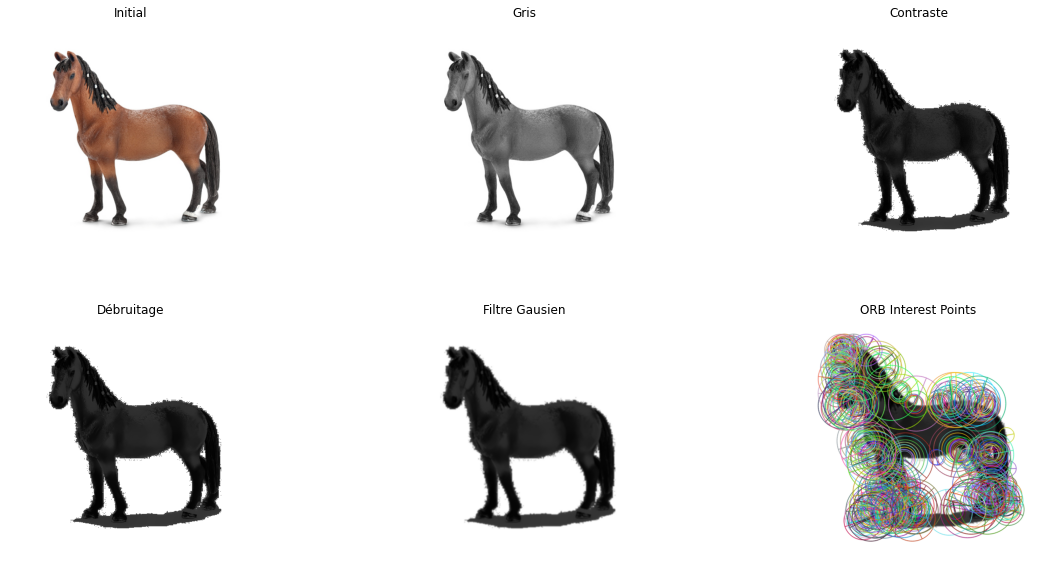

In [8]:
s3 = boto3.client("s3")
# fetching object from bucket
file_obj = s3.get_object(Bucket=AWS_S3_BUCKET, Key="cheval.jpeg")
# reading the file content in bytes
file_content = file_obj["Body"].read()

#rows = 1
#columns = 4
fig = plt.figure(figsize=(20, 10))

# creating 1D array from bytes data range between[0,255]
np_array = np.frombuffer(file_content, np.uint8)

# decoding array
fig.add_subplot(2, 3, 1)

image_np = cv2.imdecode(np_array, cv2.IMREAD_COLOR)
plt.imshow(cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Initial")


# converting image from RGB to Grayscale
fig.add_subplot(2, 3, 2)
gray = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Gris")


# Amélioration contraste
fig.add_subplot(2, 3, 3)
image_cont = cv2.equalizeHist(gray)   # égalisation histogramme
plt.imshow(cv2.cvtColor(image_cont, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Contraste")

# Débruitage
fig.add_subplot(2, 3, 4)
image_denoise = cv2.fastNlMeansDenoising(image_cont)
plt.imshow(cv2.cvtColor(image_denoise, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Débruitage")


# filtre gaussien
fig.add_subplot(2, 3, 5)
image_filtre_2 = cv2.GaussianBlur(image_denoise, (5, 5), 1)
plt.imshow(cv2.cvtColor(image_filtre_2, cv2.COLOR_BGR2RGB))
plt.axis('off')
plt.title("Filtre Gausien")

#Features Research
orb = cv2.ORB_create()
key_points, description = orb.detectAndCompute(image_filtre_2, None)
img_building_keypoints = cv2.drawKeypoints(image_filtre_2,
                                           key_points,
                                           image_filtre_2,
                                           flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)  # Draw circles.
fig.add_subplot(2, 3, 6)
plt.imshow(img_building_keypoints)
plt.axis('off')
plt.title("ORB Interest Points")


In [9]:
print("Nombre de descripteurs : ", description.shape[0])
print("\n \n")
print(np.array(description))


Nombre de descripteurs :  500

 

[[218 252 246 ... 240  39 187]
 [ 38 169 224 ... 222 210 136]
 [222  76 182 ... 241  49   1]
 ...
 [ 34 165 210 ...  72 241 136]
 [ 60 193 120 ... 154 210 160]
 [114 224  80 ... 186  66 137]]


# <font color='green'>Entraînement sur plusieurs images par CNN</font>

Il ne doit pas y avoir d'espace dans le nom des dossiers ni des images mises sur le s3 donc :
sur mac avoir homebrew et rename d'installer puis faire la commande dans le terminal :
find . -name "* *" -type d | rename 's/ /_/g'   modif d par f pour fichier



Le transfert learning utilise des modèles pré-entraînés comme point de départ, il permet de développer rapidement des modèles performants et résoudre efficacement des problèmes complexes en Computer Vision ou Natural Language Processing, NLP.

Le Transfer Learning repose sur une idée simple, celle de ré-exploiter les connaissances acquises dans d’autres configurations (sources) pour la résolution d’un problème particulier (cible).

CNN (réseau de neurones par convolution) est un empilement de couches de neurones qui utilise un modèle pré-entraîné comme extracteur de features. Ces couches apprennent différentes caractéristiques en fonction du niveau où elles se situent. Plus la couche se situe en profondeur, plus elle permet d’extraire des features spécifiques.

## <font color='blue'>Connexion au S3</font>

In [10]:
#Connexion
session = boto3.session.Session(aws_access_key_id=access_id,aws_secret_access_key=access_key)
s3_client = session.client(service_name='s3', region_name="eu-west-3")
bucket = s3_client.list_objects_v2(Bucket="p8-ald")    #, Prefix='Sample'
s3 = boto3.resource('s3',
                    aws_access_key_id=access_id,
                    aws_secret_access_key=access_key) 


In [11]:
#On vérifie que la connexion est bien établie
response = s3_client.get_object(Bucket=AWS_S3_BUCKET, Key="cheval.jpeg")
status = response.get("ResponseMetadata", {}).get("HTTPStatusCode")

if status == 200:
    print(f"Successful S3 get_object response. Status - {status}")
else:
    print(f"Unsuccessful S3 get_object response. Status - {status}")
    

Successful S3 get_object response. Status - 200


## <font color='blue'>Mise en place d'une session spark</font>

In [12]:
# Instantiation d'une SparkSession
spark = SparkSession.builder.config("spark.driver.memory", "16g").appName('P8').getOrCreate()  #local [*] machine avec 16Go ram
spark


In [13]:
#Instanciation d'un Spark Context qui gère les différents clusters pour parlléliser le travail
config = SparkConf().set('spark.rpc.message.maxSize', '256')
sc = SparkContext.getOrCreate(conf=config)


On indique les bons fichiers .jar à pyspark pour la suite du projet.

In [14]:
#Mise en place des argumenst adapté nécessaires à pyspark
os.environ['PYSPARK_SUBMIT_ARGS']= '--packages com.amazonaws:aws-java-sdk-pom:1.10.34, org.apache.hadoop:hadoop-common:3.2.0,org.apache.hadoop:hadoop-client:3.2.0,org.apache.hadoop:hadoop-aws:3.2.0,com.amazonaws:aws-java-sdk-bundle:1.11.874,com.google.guava:guava:27.1-jre, databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell'

#databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11, non utile ici car non utilisation de sparkDL qui n'est plus pris en charge

#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:2.7.4,databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell '
#os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.amazonaws:aws-java-sdk-pom:1.10.34,org.apache.hadoop:hadoop-aws:3.2.0,databricks:spark-deep-learning:1.5.0-spark2.4-s_2.11 pyspark-shell'


#for hadoop 2.7 --packages
#org.apache.hadoop:hadoop-common:3.3.0,org.apache.hadoop:hadoop-client:3.3.0,org.apache.hadoop:hadoop-aws:3.3.0,com.amazonaws:aws-java-sdk-bundle:1.11.563,com.google.guava:guava:27.1-jre  


## <font color='blue'>Extraction liste d'images</font>

Créer et définir les paramètres de la configuration Hadoop afin de pouvoir récupérer les données dans S3.

Load Data par la création du RDD des images en mode binaryfile avec le path de chaque image

In [15]:
# NE MARCHE QUE SI IL N'Y A PAS D'ESPACE DANS LE CHEMIN
aws_access_key = access_id

aws_secret_key = access_key

hadoop_conf = spark._jsc.hadoopConfiguration()


hadoop_conf.set("fs.s3a.impl","org.apache.hadoop.fs.s3a.S3AFileSystem")

hadoop_conf.set("com.amazonaws.services.s3.enableV4",
"true")

hadoop_conf.set("fs.s3a.aws.credentials.provider","org.apache.hadoop.fs.s3a.SimpleAWSCredentialsProvider")

hadoop_conf.set("fs.s3a.endpoint", "s3.amazonaws.com")

hadoop_conf.set("fs.s3a.access.key", aws_access_key)

hadoop_conf.set("fs.s3a.secret.key", aws_secret_key)

path = f"s3a://{AWS_S3_BUCKET}/Sample/*"
#path = f"s3a://{AWS_S3_BUCKET}/*"

#Création RDD df
#Binaryfile = opération optimisée comparer à image pure
df = spark.read.format("binaryFile").option("recursiveFileLookup", "true").load(path) #.option("pathGlobFilter", "*.jpeg")

print('chargement effectué')
print('Nombres d\'images :', df.count())   

#Suppression de colonne inutiles
spark_df = df.drop("modificationTime", "length")

def get_catego (url):
    list_file = url.split("/")
    catego = list_file[-2]
    return catego

udf_categ = udf(get_catego, StringType())
spark_df = spark_df.withColumn("categorie", udf_categ('path'))

spark_df.show(truncate=20)


chargement effectué
Nombres d'images : 1310
+--------------------+--------------------+--------------+
|                path|             content|     categorie|
+--------------------+--------------------+--------------+
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|Pineapple_Mini|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|Pineapple_Mini|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|Pineapple_Mini|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|Pineapple_Mini|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://p8-ald/Samp...|[FF D8 FF E0 00 1...|     Raspberry|
|s3a://p8-al

## <font color='blue'>Préparation du modèle</font>

Téléchargement du modèle pour la featurisation sans les couches supérieures

Ici, transfer learning via le réseau VGG16 pré-entrainé sur une base d'images riche (imagenet). Le VGG-16 (Very Deep Convolutional Networks for Large-Scale Image Recognition, 16 couches) est l'un des modèles pré-entraînés les plus populaires pour la classification des images.

In [16]:
#modèle sans les couches supérieures qui se base sur imagenet 
model = VGG16(weights="imagenet", include_top=False)
#pas d'entrainement car on veut juste les features d'image
#model.summary()  # verify that the top layer is removed


Les workers de Spark ont besoin d'accéder au modèle et à ses poids.
Téléchargement du modèle vers le pilote Spark, puis diffusion des poids aux workers dirigés par le sc (sparkContext).


In [17]:
bc_model_weights = sc.broadcast(model.get_weights())


In [18]:
def model_create():
    """
    Returns a VGG16 model with top layer removed and broadcasted pretrained weights.
    """
    # Charger VGG16 pré-entraîné sur ImageNet et sans les couches fully-connected (couches hautes).
    model = VGG16(weights="imagenet", include_top=False)
    model.set_weights(bc_model_weights.value)
    return model


## <font color='blue'>Préparation du préprocessing</font>

Préprocessing à appliquer à chaque image à partir du contenu du RDD au format bianaire.

In [19]:
def preprocess(content):
    """
    Preprocesses raw image bytes for prediction.
    """
    img = Image.open(io.BytesIO(content)) #ouvrir l'image grâce à sa forme binaire
    #mais l'image est ouverte en mémoire quelque instant par soucis d'optimisation est de performance
    arr = img_to_array(img) #L'image bianire est transformée en tableau pour ensuite avoir le préprocessing de VGG16
    return preprocess_input(arr)


## <font color='blue'>Features extraction</font>

Application du préprocessing et de la recherche de feature pour chaque image composant le spark dataframe qui est transformé en series, grâce au modèle préentraîné choisi.
En entrée de la fonction c'est un pd.series du lien de chaque image et en sortie un pd.series de features trouvés.

In [20]:
def featurize_series(model, content_series):
    """
    Featurize a pd.Series of raw images using the input model.
    :return: a pd.Series of image features
    """
    input = np.stack(content_series.map(preprocess)) #préprocessing appliqué à la totalité de la série d'image
    #np.stack = travailler verticalement au lieu d'horizontalement
    preds = model.predict(input) #Prédiction grâce au modèle loadé
    #transformation de la sortie en vecteur en une dimension (la sortie d'un modèle peut être multidimentionnel)
    output = [p.flatten() for p in preds] #applatissement sortie feature de l'image
    return pd.Series(output) #transformation type de sortie en séries


Les générateurs sont des itérateurs utilisables qu'une seule fois. Les générateurs ne stockent pas toutes les valeurs en mémoire, ils génèrent les valeurs à la volée.

yield est un mot-clé qui est utilisé comme return, sauf que la fonction renverra un générateur.

Cette caractéristique permet de gérer une fonction qui retournerait un ensemble important de valeurs. Le code de la fonction n'est pas entièrement exécuté à chaque appel, il est exécuté la première fois puis à chaque appel du générateur, la boucle est incrémentée d'un cran. Le générateur s'arrête quand il n'y a plus de valeur à retourner. Cela permet également de masquer la complexité du code lié au générateur.


In [21]:
@pandas_udf('array<float>', PandasUDFType.SCALAR_ITER) #donne le type de sortie de la fonction
#@pandas_udf('long', functionType=PandasUDFType.SCALAR)

def feature_research(content_series_tot):
    '''
    This method is a Scalar Iterator pandas UDF wrapping our featurization function.
    The decorator specifies that this returns a Spark DataFrame column of type ArrayType(FloatType).
  
    :param content_series_iter: This argument is an iterator over batches of data, where each batch
                              is a pandas Series of image data.
      -'''
    #on se base sur une unique colonne pour faire la recherche de feature qui est transformée en type series
    model = model_create()   #chargement du model prédéfini
    #pour chaque batch du dataframe (créer par spark lors de l'appel général),on applique la totalité des fonction précédentes
    for content_series in content_series_tot: 
        yield featurize_series(model, content_series)
        

/home/ubuntu/spark-3.0.1-bin-hadoop3.2/python/pyspark/sql/pandas/functions.py:383: UserWarning: In Python 3.6+ and Spark 3.0+, it is preferred to specify type hints for pandas UDF instead of specifying pandas UDF type which will be deprecated in the future releases. See SPARK-28264 for more details.
  warnings.warn(


Application la featurisation au spark DataFrame complet

In [22]:
spark_df_features = spark_df.select(col("path"), col("categorie"), feature_research("content").alias("image_features")) 
#repartition() : nombre de partionnement du dataframe = nombre de hash optionnel si pas cet argument, spark décide lui même du nombre d'image par groupes 


In [23]:
spark_df_features.show(truncate=20)


+--------------------+--------------+--------------------+
|                path|     categorie|      image_features|
+--------------------+--------------+--------------------+
|s3a://p8-ald/Samp...|     Raspberry|[8.752506, 0.0, 0...|
|s3a://p8-ald/Samp...|     Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://p8-ald/Samp...|Pineapple_Mini|[0.0, 0.0, 10.675...|
|s3a://p8-ald/Samp...|Pineapple_Mini|[0.0, 0.0, 26.388...|
|s3a://p8-ald/Samp...|     Raspberry|[5.615052, 0.0, 2...|
|s3a://p8-ald/Samp...|     Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://p8-ald/Samp...|     Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://p8-ald/Samp...|Pineapple_Mini|[0.0, 0.0, 12.811...|
|s3a://p8-ald/Samp...|     Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://p8-ald/Samp...|Pineapple_Mini|[0.0, 0.0, 18.474...|
|s3a://p8-ald/Samp...|     Raspberry|[2.3940241, 0.0, ...|
|s3a://p8-ald/Samp...|     Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://p8-ald/Samp...|     Raspberry|[0.0, 0.0, 0.0, 0...|
|s3a://p8-ald/Samp...|Pineapple_Mini|[0.0, 0.0, 0.0, 0..

In [24]:
spark_df_features.dtypes


[('path', 'string'),
 ('categorie', 'string'),
 ('image_features', 'array<float>')]

In [25]:
spark_df_features.count()


1310

## <font color='blue'>Réduction de dimension : PCA</font>

In [26]:
from pyspark.sql.functions import size, col
spark_df_features.select(size(col("image_features"))).show(1)


+--------------------+
|size(image_features)|
+--------------------+
|                4608|
+--------------------+
only showing top 1 row



In [27]:
nb_composante = len(spark_df_features.select('image_features').take(1)[0][0])
nb_composante


4608

In [28]:
images = spark_df_features.select(spark_df_features.columns[:1])
features = spark_df_features.drop("path")


In [29]:
# Les données images sont converties au format vecteur dense
convert = udf(lambda r: Vectors.dense(r), VectorUDT())
spark_df_features = spark_df_features.withColumn('image_features', convert('image_features'))

#spark_df_features.show(truncate=20)


In [30]:
# Standardisation : Mise à l'échelle à l'aide de la moyenne égal à 0 et l'écart-type à 1
standardizer = StandardScaler(inputCol="image_features", outputCol="image_features_scal")
mod = standardizer.fit(spark_df_features)
temp = mod.transform(spark_df_features)
spark_df_features = temp.drop("image_features")


In [31]:
# PCA.
pca = PCA(k=nb_composante, inputCol="image_features_scal", outputCol="pca_image_features")
model = pca.fit(spark_df_features.select('image_features_scal'))  #model = pca.fit(spark_df_features.select('image_features'))


Text(0.5, 1.0, 'Courbe de variances cumulées')

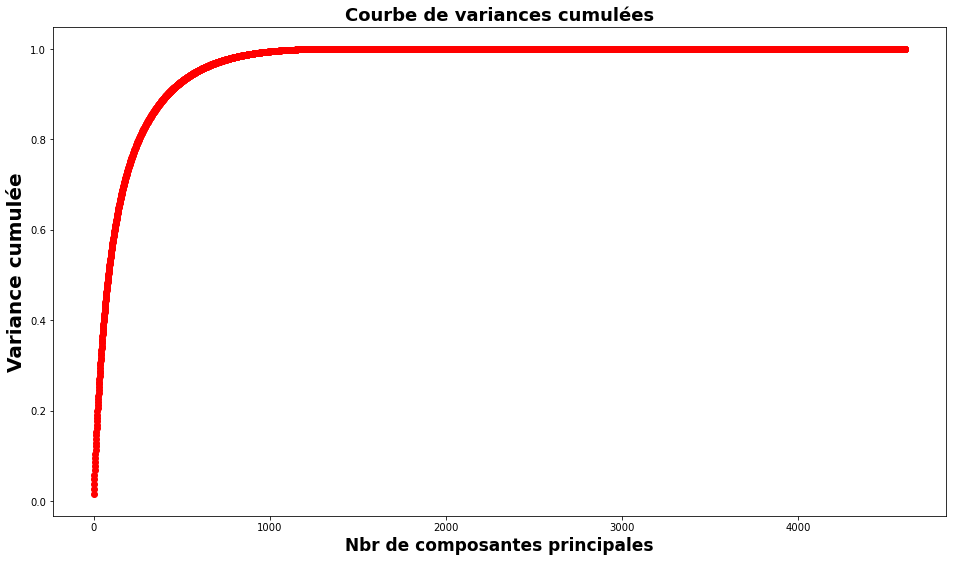

In [32]:
plt.figure(figsize=(16, 9))
plt.ylabel("Variance cumulée", weight='bold', size=20)
plt.xlabel('Nbr de composantes principales', weight='bold', size=17)
plt.plot(model.explainedVariance.cumsum(),c="red",marker='o')
plt.title('Courbe de variances cumulées', size=18, weight='bold')
#plt.plot([0, spark_df_features.shape[1]], [0.95, 0.95])


In [33]:
c = 0
for i in model.explainedVariance.cumsum():
    c += 1
    if(i > 0.95):
        print(
            'Il faut {} composantes pour expliquer 95% de la variance du dataset'.format(c))
        break
        

Il faut 585 composantes pour expliquer 95% de la variance du dataset


In [34]:
# Réduction de dimention
pca = PCA(k=c, inputCol='image_features_scal', outputCol='image_features_reduit')
model_pca = pca.fit(spark_df_features)
spark_df_features_final = model_pca.transform(spark_df_features)
spark_df_features_final = spark_df_features_final.drop("image_features_scal")


## <font color='blue'>Sauvegarde du Dataframe Spark sur S3</font>

In [35]:
#la fonction cast permet de transformer la colonne feature de array float à string pour pouvoir être pris en compte car array n'est pas accepté pour la sauvegarde en csv
#coalesce : définit le nombre de fichier csv différents à créer. coalesce(1) signifie créer un seul csv contenant toutes les images (1 gros fichier)
spark_df_features_final.withColumn("image_features_reduit", col("image_features_reduit").cast("string")).coalesce(1).write.option("header","true").mode("Overwrite").csv(path="s3a://p8-ald/Result_Features_Sample") 


## <font color='blue'>Lecture du CSV enregistré</font>

In [36]:
path = f"s3a://{AWS_S3_BUCKET}/Result_Features_Sample/*"

df = spark.read.format("csv").option("header","true").option("recursiveFileLookup", "true").load(path)
df_csv = df.toPandas()


In [37]:
#df.show(truncate=20)
df_csv


,path,categorie,image_features_reduit
0,s3a://p8-ald/Sample/Raspberry/59_100.jpg,Raspberry,"[-11.739343823504292,-19.282922837703882,0.536..."
1,s3a://p8-ald/Sample/Raspberry/17_100.jpg,Raspberry,"[-8.932846435115184,-14.729399119040165,-0.140..."
2,s3a://p8-ald/Sample/Pineapple_Mini/249_100.jpg,Pineapple_Mini,"[-19.489664206140713,-33.34627919533664,1.2217..."
3,s3a://p8-ald/Sample/Pineapple_Mini/179_100.jpg,Pineapple_Mini,"[-15.807275228826104,-27.638582449608528,0.513..."
4,s3a://p8-ald/Sample/Raspberry/134_100.jpg,Raspberry,"[-8.853180138955645,-17.935757508158666,0.4905..."
...,...,...,...
1305,s3a://p8-ald/Sample/Hazelnut/r_135_100.jpg,Hazelnut,"[-2.4572142226263964,2.1055821299439477,1.3187..."
1306,s3a://p8-ald/Sample/Corn_Husk/12_100.jpg,Corn_Husk,"[-20.58824461965578,-0.288747260726716,0.95053..."
1307,s3a://p8-ald/Sample/Banana/r_96_100.jpg,Banana,"[-23.151807568156446,-1.4509710738453796,0.932..."
1308,s3a://p8-ald/Sample/Corn_Husk/r_218_100.jpg,Corn_Husk,"[-41.55936912915406,3.607876338022761,1.093658..."
